This analysis investigates whether eviction rates are higher near Purple Line light rail stations compared to other areas in Prince George’s and Montgomery Counties, Maryland. The research builds on prior tabular analyses by incorporating spatial methods to examine how proximity to transit infrastructure may correlate with housing instability. Using address-level eviction data from Maryland Judiciary Case Search and geospatial data for planned Line station locations, I conduct a proximity analysis to classify eviction events as either "near" or "far" from Purple Line stations (within 1 mile and beyond 1 mile, respectively). Eviction density is calculated using kernel density estimation and aggregated to Census tracts for comparison with demographic and housing variables.

In [10]:
import pandas as pd
import geopandas as gpd
import utils
import exercise03
import census_geocode

%load_ext autoreload
%autoreload 2

In [11]:
# Load warrants and make sure zip codes are stored as strings without decimals
warrants_df = pd.read_csv('md_eviction_warrents_through_2024.csv')
warrants_df['TenantZipCode'] = warrants_df['TenantZipCode'].astype('Int64').astype('string')
len(warrants_df) # How many warrants are we working with?

411040

In [12]:
# Rather than geocoding 400K+ addresses, could we get only the unique ones?
geocode_input_df = exercise03.prep_warrants_for_geocoding(warrants_df)

411040 warrants input
Reduced to 167949 unique addresses


In [13]:
# The Census Geocoder API can only accept up to 10K rows at a time, so we have to break
# our dataframe into chunks

# Split into dataframes with less than 10K rows each
geocode_input_dfs = utils.chunk_dataframe(geocode_input_df, 9999)

# Save each dataframe as a CSV without a header
utils.save_dfs_to_csv(geocode_input_dfs, 'geocode_inputs', header=False)

split dataframe into 17 chunks


In [14]:
# Geocode addresses with the Census Geocoder (set test=True to process only one file)
census_geocode.geocode_csvs('geocode_inputs', 'geocode_outputs', test=True)

TEST MODE: Processing only one file.
Processing file: geocode_inputs/df_14.csv
Saved results to: geocode_outputs/geocoderesult_df_14.csv


In [15]:
# Recombine outputs from geocoder into a single dataframe
geocode_output_df = exercise03.combine_census_geocoded_csvs('geocode_outputs')
len(geocode_output_df)

9999

In [16]:
# Merge geocoded address back onto the inputs with separate fields for address, city, state, and zip
geocoded_df = geocode_input_df.merge(geocode_output_df, left_index=True, right_index=True)
len(geocoded_df)

9999

In [17]:
# Use address, city, state, and zip columns to join geocodes onto original warrant records
warrants_df = warrants_df.merge(geocoded_df, on=['TenantAddress','TenantCity','TenantState','TenantZipCode'])
len(warrants_df)

15112

In [18]:
# Convert warrants into a geodataframe with points
warrants_gdf = utils.lonlat_str_to_geodataframe(warrants_df, 'match_lon_lat')

In [19]:
# What proportion of records have points?
len(warrants_gdf[warrants_gdf.lon.notnull()]) / len(warrants_gdf)

0.948782424563261

In [20]:
# What proportion of records have exact geocode matches?
len(warrants_gdf[warrants_gdf.match_type == 'Exact']) / len(warrants_gdf)

0.5974060349391213

In [21]:
!pip install pyarrow
warrants_gdf.to_parquet('md_eviction_warrants_through_2024.geoparquet')

In [22]:
gdf = gpd.read_parquet('md_eviction_warrants_through_2024.geoparquet')

In [23]:
gdf.columns.tolist()

['ID',
 'EventDate',
 'EventType',
 'EventComment',
 'County',
 'Location',
 'TenantAddress',
 'TenantCity',
 'TenantState',
 'TenantZipCode',
 'CaseType',
 'CaseNumber',
 'EvictedDate',
 'Source',
 'SourceDate',
 'Year',
 'EvictionYear',
 'unique_id',
 'input_address',
 'match_status',
 'match_type',
 'match_address',
 'match_lon_lat',
 'match_tiger_line_id',
 'match_tiger_line_side',
 'lon',
 'lat',
 'geometry']

In [25]:
#0: Filter eviction cases to only those in PG and Montgomery Counties
# Normalize County column for safe matching
warrants_gdf['County'] = warrants_gdf['County'].str.lower().str.strip()

# Filter for Prince George's and Montgomery counties
pg_mo_evictions = warrants_gdf[
    warrants_gdf['County'].str.contains("prince george") |
    warrants_gdf['County'].str.contains("montgomery")
].copy()

In [26]:
#1: Load Purple Line station data
purple_line_stations = gpd.read_file('Purple_Line_stations/Purple_Line_stattions.shp')

In [27]:
#2: Create a 1-mile buffer around each station to define “near” area

# Reproject to a projected CRS appropriate for Maryland (units = meters)
buffers = purple_line_stations.to_crs(epsg=2248)

# Buffer 1 mile (1,609.34 meters)
buffers['geometry'] = buffers.buffer(1609.34)

In [28]:
#3: Spatial join - is eviction inside buffer?
pg_mo_evictions = pg_mo_evictions.to_crs(epsg=2248)
joined = pg_mo_evictions.sjoin(buffers, how='left', predicate='within')
joined['near_pl_station'] = joined['index_right'].notnull()
pg_mo_evictions = joined.drop(columns=['index_right'])

In [29]:
#4: Compare eviction rates
near_pct = pg_mo_evictions['near_pl_station'].mean()
print(f"Eviction filings near Purple Line stations: {near_pct:.2%}")
print(f"Eviction filings elsewhere: {(1 - near_pct):.2%}")

Eviction filings near Purple Line stations: 1.25%
Eviction filings elsewhere: 98.75%


This doesn't really get at the question I was really trying to ask. Below is additional analysis that asks: Are eviction rates higher in census tracts that intersect a 1-mile buffer around Purple Line stations compared to those that don’t?

In [1]:
pip install censusdis geopandas pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 8.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 10.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 10.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 9.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 9.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.15.1
    Uninstalling Pygments-2.15.1:
      Successfully uninstalled Pygments-2.15.1
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninst

In [32]:
#1: Pull tracts + renter data from ACS
tracts = gpd.read_file("tl_2023_24_tract/tl_2023_24_tract.shp")
tracts = tracts.to_crs(epsg=2248)  # Project for spatial ops

tracts = tracts[tracts['COUNTYFP'].isin(['031', '033'])].copy()
tracts['GEOID'] = tracts['GEOID'].astype(str)

renter_data = pd.read_csv("acs2023_5yr_B25003_14000US24037876102/acs2023_5yr_B25003_14000US24037876102.csv")

# Rename and keep only what you need
renter_data = renter_data.rename(columns={
    'geoid': 'GEOID',
    'B25003001': 'total_housing_units',
    'B25003003': 'renter_occupied_units'
})

# Ensure GEOID format matches
renter_data['GEOID'] = renter_data['GEOID'].astype(str).str.zfill(11)

# Merge with tract shapes
tracts = tracts.merge(renter_data[['GEOID', 'total_housing_units', 'renter_occupied_units']], on='GEOID', how='left')

#Calculate % Renter Rate
tracts['pct_renter'] = tracts['renter_occupied_units'] / tracts['total_housing_units']
tracts['renter_occupied_units'] = tracts['renter_occupied_units'].fillna(0)

In [33]:
#2: Create 1-mile buffers
purple_line_stations = gpd.read_file('Purple_Line_stations/Purple_Line_stattions.shp')
buffers = purple_line_stations.to_crs(epsg=2248)
buffers['geometry'] = buffers.buffer(1609.34)

In [36]:
#3: Flag tracts that intersect with buffer
tracts['near_pl_station'] = tracts.intersects(buffers.union_all())

In [37]:
#4: Spatial join: assign evictions to tracts
# Make sure evictions are projected correctly
pg_mo_evictions = pg_mo_evictions.to_crs(epsg=2248)

# Spatial join: which tract each eviction falls in
evictions_with_tracts = gpd.sjoin(pg_mo_evictions, tracts, how='left', predicate='within')

# Count evictions per tract
eviction_counts = evictions_with_tracts.groupby('GEOID').size().reset_index(name='eviction_count')

# Merge back into tract GeoDataFrame
tracts = tracts.merge(eviction_counts, on='GEOID', how='left')
tracts['eviction_count'] = tracts['eviction_count'].fillna(0)

# Calculate eviction rate per 1,000 renter households
tracts['eviction_rate_per_1k_renters'] = (tracts['eviction_count'] / tracts['renter_occupied_units']) * 1000

/opt/miniconda3/envs/688y/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


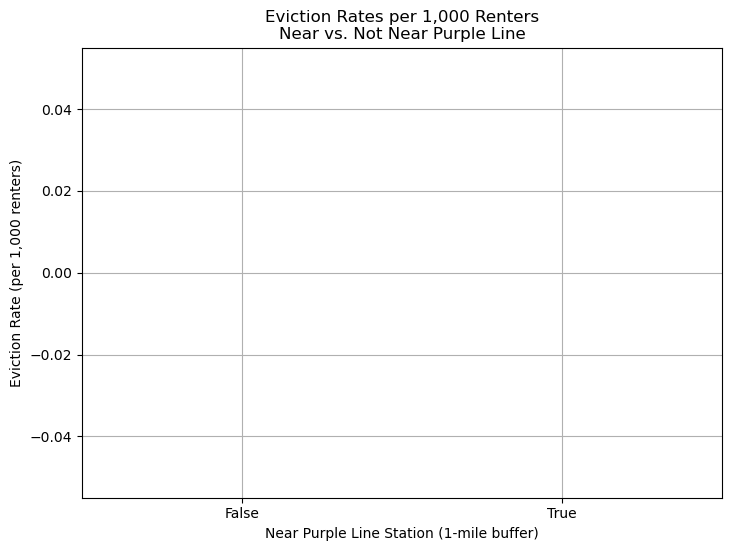

In [38]:
#5: Boxplot comparing eviction rates by proximity
import matplotlib.pyplot as plt

tracts.boxplot(
    column='eviction_rate_per_1k_renters',
    by='near_pl_station',
    figsize=(8, 6)
)
plt.title('Eviction Rates per 1,000 Renters\nNear vs. Not Near Purple Line')
plt.suptitle('')
plt.xlabel('Near Purple Line Station (1-mile buffer)')
plt.ylabel('Eviction Rate (per 1,000 renters)')
plt.show()


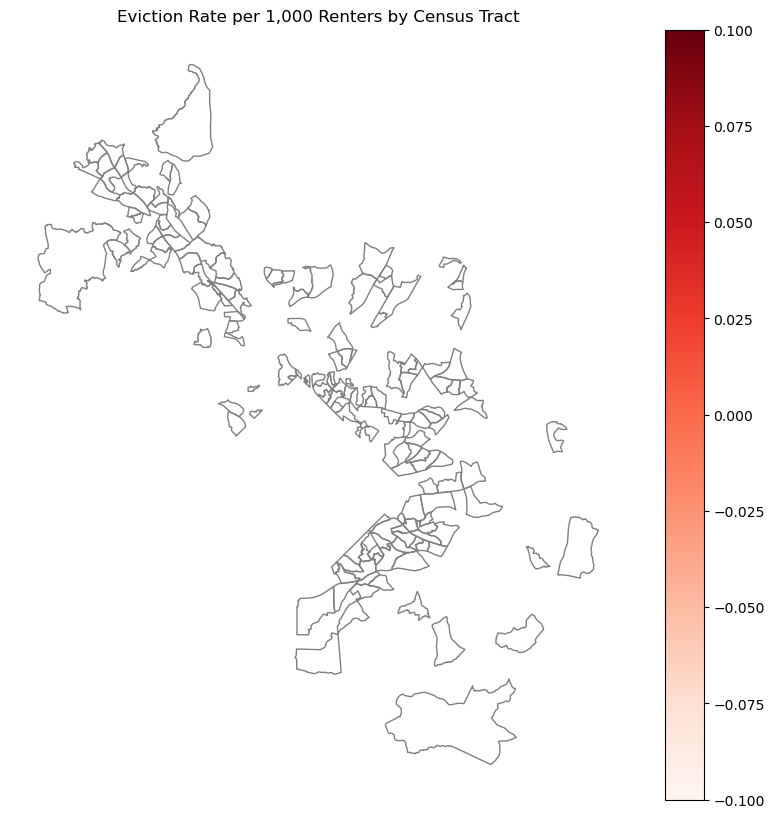

In [39]:
#6: Map eviction rates
tracts.plot(
    column='eviction_rate_per_1k_renters',
    cmap='Reds',
    legend=True,
    figsize=(10, 10),
    edgecolor='grey'
)
plt.title('Eviction Rate per 1,000 Renters by Census Tract')
plt.axis('off')
plt.show()